# Chapter 4. Geocentric Models

In [1]:
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as onp
import pandas as pd
from scipy.interpolate import BSpline
from scipy.stats import gaussian_kde

from jax import lax, vmap
import jax.numpy as np
from jax.random import PRNGKey

import numpyro
from numpyro.contrib.autoguide import (AutoContinuousELBO,
                                       AutoLaplaceApproximation)
from numpyro.diagnostics import hpdi, print_summary
import numpyro.distributions as dist
from numpyro.infer import Predictive, SVI, init_to_value
import numpyro.optim as optim

%config InlineBackend.figure_formats = ["svg"]
warnings.formatwarning = (lambda message, category, *args, **kwargs:
                          "{}: {}\n".format(category.__name__, message))
az.style.use("arviz-darkgrid")

### Code 4.1

In [2]:
pos = np.sum(dist.Uniform(-1, 1).sample(PRNGKey(0), (1000, 16)), -1)

### Code 4.2

In [3]:
np.prod(1 + dist.Uniform(0, 0.1).sample(PRNGKey(0), (12,)))

DeviceArray(1.7294353, dtype=float32)

### Code 4.3

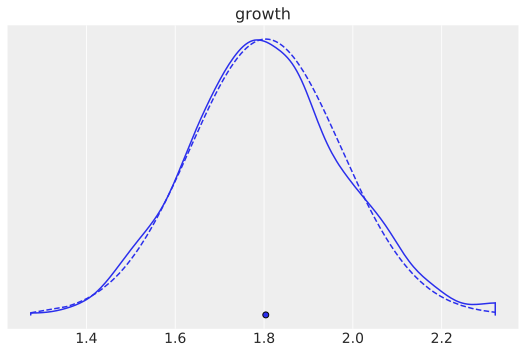

In [4]:
growth = np.prod(1 + dist.Uniform(0, 0.1).sample(PRNGKey(0), (1000, 12)), -1)
az.plot_density({"growth": growth}, credible_interval=1)
x = np.sort(growth)
plt.plot(x, np.exp(dist.Normal(np.mean(x), np.std(x)).log_prob(x)), "--");

### Code 4.4

In [5]:
big = np.prod(1 + dist.Uniform(0, 0.5).sample(PRNGKey(0), (1000, 12)), -1)
small = np.prod(1 + dist.Uniform(0, 0.01).sample(PRNGKey(0), (1000, 12)), -1)

### Code 4.5

In [6]:
log_big = np.log(np.prod(
    1 + dist.Uniform(0, 0.5).sample(PRNGKey(0), (1000, 12)), -1))

### Code 4.6

In [7]:
w = 6; n = 9
p_grid = np.linspace(start=0, stop=1, num=100)
prob_binom = np.exp(dist.Binomial(n, p_grid).log_prob(w))
posterior = prob_binom * np.exp(dist.Uniform(0, 1).log_prob(p_grid))
posterior = posterior / np.sum(posterior)

### Code 4.7

In [8]:
Howell1 = pd.read_csv("../data/Howell1.csv", sep=";")
d = Howell1

### Code 4.8

In [9]:
d.info()
d.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 544 entries, 0 to 543
Data columns (total 4 columns):
height    544 non-null float64
weight    544 non-null float64
age       544 non-null float64
male      544 non-null int64
dtypes: float64(3), int64(1)
memory usage: 17.1 KB


height     weight   age  male
0  151.765  47.825606  63.0     1
1  139.700  36.485807  63.0     0
2  136.525  31.864838  65.0     0
3  156.845  53.041915  41.0     1
4  145.415  41.276872  51.0     0

### Code 4.9

In [10]:
print_summary(dict(zip(d.columns, d.T.values)), 0.89, False)


                mean       std    median      5.5%     94.5%     n_eff     r_hat
       age     29.34     20.75     27.00      0.00     57.00    186.38      1.03
    height    138.26     27.60    148.59     90.81    170.18    218.68      1.06
      male      0.47      0.50      0.00      0.00      1.00    670.75      1.00
    weight     35.61     14.72     40.06     11.37     55.71    305.62      1.05



### Code 4.10

In [11]:
d.height

0      151.765
1      139.700
2      136.525
3      156.845
4      145.415
        ...   
539    145.415
540    162.560
541    156.210
542     71.120
543    158.750
Name: height, Length: 544, dtype: float64

### Code 4.11

In [12]:
d2 = d[d.age >= 18]

### Code 4.12

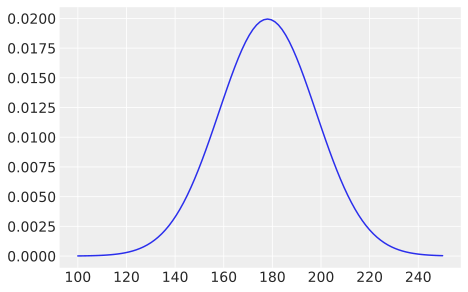

In [13]:
x = np.linspace(100, 250, 101)
plt.plot(x, np.exp(dist.Normal(178, 20).log_prob(x)));

### Code 4.13

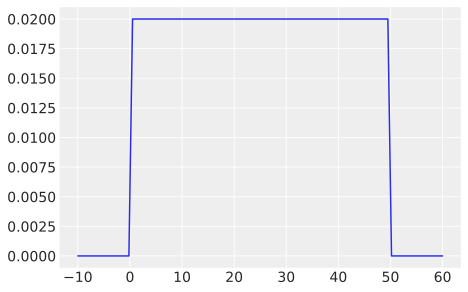

In [14]:
x = np.linspace(-10, 60, 101)
plt.plot(x, np.exp(dist.Uniform(0, 50, validate_args=True).log_prob(x)));

### Code 4.14

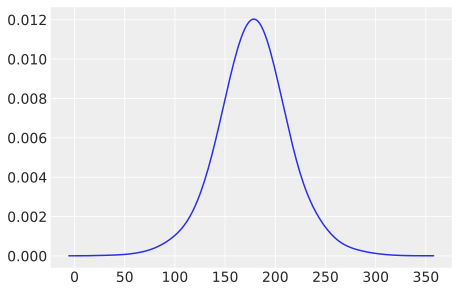

In [15]:
sample_mu = dist.Normal(178, 20).sample(PRNGKey(0), (int(1e4),))
sample_sigma = dist.Uniform(0, 50).sample(PRNGKey(1), (int(1e4),))
prior_h = dist.Normal(sample_mu, sample_sigma).sample(PRNGKey(2))
az.plot_kde(prior_h);

### Code 4.15

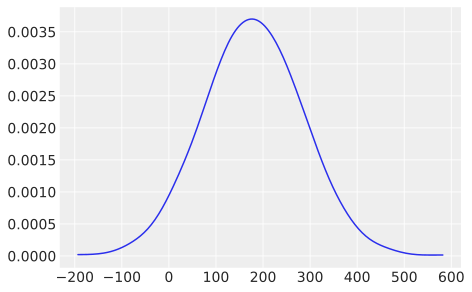

In [16]:
sample_mu = dist.Normal(178, 100).sample(PRNGKey(0), (int(1e4),))
prior_h = dist.Normal(sample_mu, sample_sigma).sample(PRNGKey(2))
az.plot_kde(prior_h);

### Code 4.16

In [17]:
mu_list = np.linspace(start=150, stop=160, num=100)
sigma_list = np.linspace(start=7, stop=9, num=100)
mesh = np.meshgrid(mu_list, sigma_list)
post = {"mu": mesh[0].reshape(-1), "sigma": mesh[1].reshape(-1)}
post["LL"] = vmap(lambda mu, sigma: np.sum(dist.Normal(mu, sigma).log_prob(
    d2.height.values)))(post["mu"], post["sigma"])
logprob_mu = dist.Normal(178, 20).log_prob(post["mu"])
logprob_sigma = dist.Uniform(0, 50).log_prob(post["sigma"])
post["prob"] = post["LL"] + logprob_mu + logprob_sigma
post["prob"] = np.exp(post["prob"] - np.max(post["prob"]))

### Code 4.17

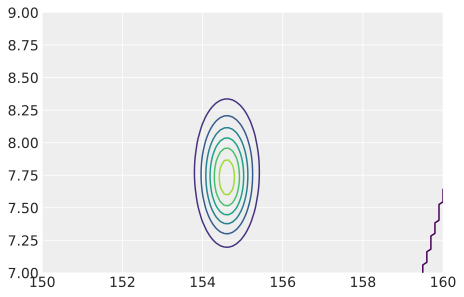

In [18]:
plt.contour(post["mu"].reshape(100, 100), post["sigma"].reshape(100, 100),
            post["prob"].reshape(100, 100));

### Code 4.18

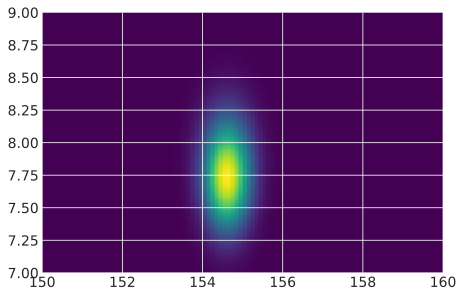

In [19]:
plt.imshow(post["prob"].reshape(100, 100),
           origin="lower", extent=(150, 160, 7, 9), aspect="auto");

### Code 4.19

In [20]:
prob = post["prob"] / np.sum(post["prob"])
sample_rows = dist.Categorical(probs=prob).sample(PRNGKey(0), (int(1e4),))
sample_mu = post["mu"][sample_rows]
sample_sigma = post["sigma"][sample_rows]

### Code 4.20

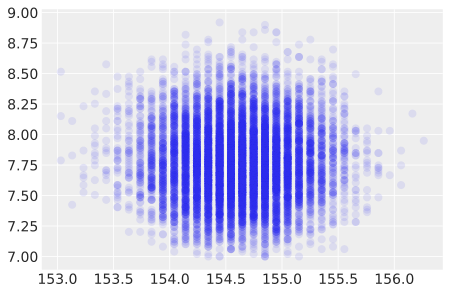

In [21]:
plt.scatter(sample_mu, sample_sigma, s=64, alpha=0.1, edgecolor="none");

### Code 4.19

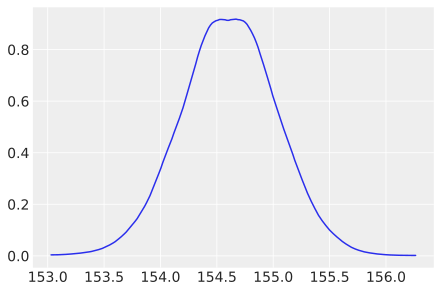

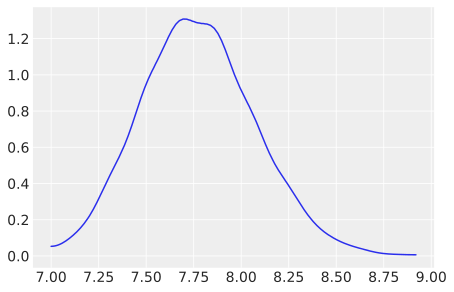

In [22]:
az.plot_kde(sample_mu)
plt.show()
az.plot_kde(sample_sigma);

### Code 4.22

In [23]:
print(hpdi(sample_mu, 0.89))
print(hpdi(sample_sigma, 0.89))

[153.93939 155.15152]
[7.3030305 8.232324 ]


### Code 4.23

In [24]:
d3 = d2.height.sample(n=20)

### Code 4.24

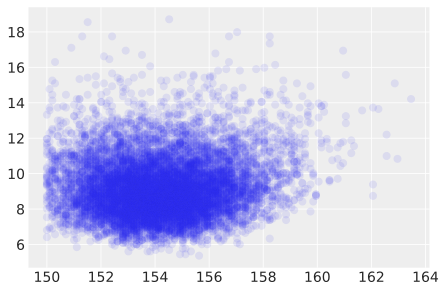

In [25]:
mu_list = np.linspace(start=150, stop=170, num=200)
sigma_list = np.linspace(start=4, stop=20, num=200)
mesh = np.meshgrid(mu_list, sigma_list)
post2 = {"mu": mesh[0].reshape(-1), "sigma": mesh[1].reshape(-1)}
post2["LL"] = vmap(lambda mu, sigma: np.sum(
    dist.Normal(mu, sigma).log_prob(d3.values)))(post2["mu"], post2["sigma"])
logprob_mu = dist.Normal(178, 20).log_prob(post2["mu"])
logprob_sigma = dist.Uniform(0, 50).log_prob(post2["sigma"])
post2["prob"] = post2["LL"] + logprob_mu + logprob_sigma
post2["prob"] = np.exp(post2["prob"] - np.max(post2["prob"]))
prob = post2["prob"] / np.sum(post2["prob"])
sample2_rows = dist.Categorical(probs=prob).sample(PRNGKey(0), (int(1e4),))
sample2_mu = post2["mu"][sample2_rows]
sample2_sigma = post2["sigma"][sample2_rows]
plt.scatter(sample2_mu, sample2_sigma, s=64, alpha=0.1, edgecolor="none");

### Code 4.25

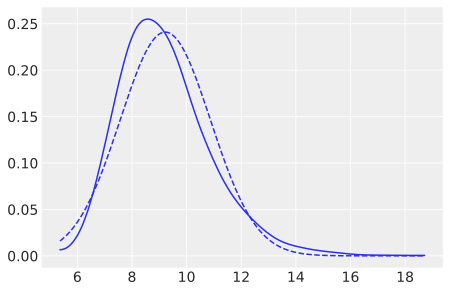

In [26]:
az.plot_kde(sample2_sigma)
x = np.sort(sample2_sigma)
plt.plot(x, np.exp(dist.Normal(np.mean(x), np.std(x)).log_prob(x)), "--");

### Code 4.26

In [27]:
Howell1 = pd.read_csv("../data/Howell1.csv", sep=";")
d = Howell1
d2 = d[d["age"] >= 18]

### Code 4.27

In [28]:
def flist(height):
    mu = numpyro.sample("mu", dist.Normal(178, 20))
    sigma = numpyro.sample("sigma", dist.Uniform(0, 50))
    numpyro.sample("height", dist.Normal(mu, sigma), obs=height)

### Code 4.28

In [29]:
m4_1 = AutoLaplaceApproximation(flist)
svi = SVI(flist, m4_1, optim.Adam(1), AutoContinuousELBO(),
          height=d2.height.values)
init_state = svi.init(PRNGKey(0))
state, loss = lax.scan(lambda x, i: svi.update(x), init_state, np.zeros(2000))
p4_1 = svi.get_params(state)

### Code 4.29

In [30]:
samples = m4_1.sample_posterior(PRNGKey(1), p4_1, (1000,))
print_summary(samples, 0.89, False)


                mean       std    median      5.5%     94.5%     n_eff     r_hat
        mu    154.60      0.40    154.60    154.00    155.28    995.06      1.00
     sigma      7.76      0.30      7.76      7.33      8.26   1007.15      1.00



### Code 4.30

In [31]:
start = {"mu": d2.height.mean(), "sigma": d2.height.std()}
m4_1 = AutoLaplaceApproximation(flist, init_strategy=init_to_value(start))
svi = SVI(flist, m4_1, optim.Adam(0.1), AutoContinuousELBO(),
          height=d2.height.values)
init_state = svi.init(PRNGKey(0))
state, loss = lax.scan(lambda x, i: svi.update(x), init_state, np.zeros(2000))
p4_1 = svi.get_params(state)

### Code 4.31

In [32]:
def model(height):
    mu = numpyro.sample("mu", dist.Normal(178, 0.1))
    sigma = numpyro.sample("sigma", dist.Uniform(0, 50))
    numpyro.sample("height", dist.Normal(mu, sigma), obs=height)

m4_2 = AutoLaplaceApproximation(model)
svi = SVI(model, m4_2, optim.Adam(1), AutoContinuousELBO(),
          height=d2.height.values)
init_state = svi.init(PRNGKey(0))
state, loss = lax.scan(lambda x, i: svi.update(x), init_state, np.zeros(2000))
p4_2 = svi.get_params(state)
samples = m4_2.sample_posterior(PRNGKey(1), p4_2, (1000,))
print_summary(samples, 0.89, False)


                mean       std    median      5.5%     94.5%     n_eff     r_hat
        mu    177.86      0.10    177.86    177.72    178.03    995.05      1.00
     sigma     24.57      0.94     24.60     23.01     25.96   1012.88      1.00



### Code 4.32

In [33]:
samples = m4_1.sample_posterior(PRNGKey(1), p4_1, (1000,))
vcov = np.cov(np.stack(list(samples.values()), axis=0))
vcov

DeviceArray([[0.16251372, 0.00172972],
             [0.00172972, 0.08735678]], dtype=float32)

### Code 4.33

In [34]:
print(np.diagonal(vcov))
print(vcov / np.sqrt(np.outer(np.diagonal(vcov), np.diagonal(vcov))))

[0.16251372 0.08735678]
[[1.         0.01451718]
 [0.01451718 1.        ]]


### Code 4.34

In [35]:
post = m4_1.sample_posterior(PRNGKey(1), p4_1, (int(1e4),))
{latent: list(post[latent][:6]) for latent in post}

{'mu': [154.24428, 154.48541, 154.97919, 154.2124, 155.49146, 154.82701],
 'sigma': [7.560233, 7.3066654, 7.280367, 7.811781, 7.905633, 7.978665]}

### Code 4.35

In [36]:
print_summary(post, 0.89, False)


                mean       std    median      5.5%     94.5%     n_eff     r_hat
        mu    154.61      0.41    154.61    153.93    155.25   9927.00      1.00
     sigma      7.75      0.29      7.74      7.28      8.22   9502.46      1.00



### Code 4.36

In [37]:
samples_flat = np.stack(list(post.values()))
mu, sigma = np.mean(samples_flat), np.cov(samples_flat)
post = dist.MultivariateNormal(mu, sigma).sample(PRNGKey(0), (int(1e4),))

### Code 4.37

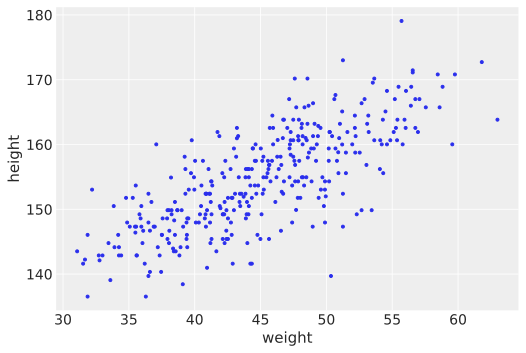

In [38]:
az.plot_pair(d2[["weight", "height"]].to_dict(orient="list"));

### Code 4.38

In [39]:
with numpyro.handlers.seed(rng=2971):
    N = 100  # 100 lines
    a = numpyro.sample("a", dist.Normal(178, 20), sample_shape=(N,))
    b = numpyro.sample("b", dist.Normal(0, 10), sample_shape=(N,))

### Code 4.39

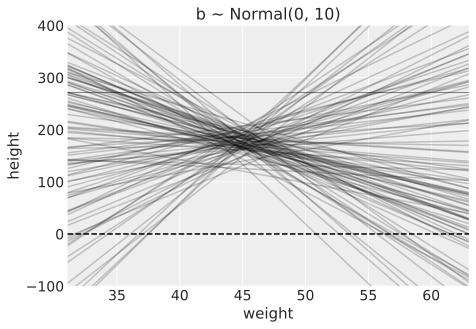

In [40]:
plt.subplot(xlim=(d2.weight.min(), d2.weight.max()), ylim=(-100, 400),
            xlabel="weight", ylabel="height")
plt.axhline(y=0, c="k", ls="--")
plt.axhline(y=272, c="k", ls="-", lw=0.5)
plt.title("b ~ Normal(0, 10)")
xbar = d2.weight.mean()
x = np.linspace(d2.weight.min(), d2.weight.max(), 101)
for i in range(N):
    plt.plot(x, a[i] + b[i] * (x - xbar), "k", alpha=0.2);

### Code 4.40

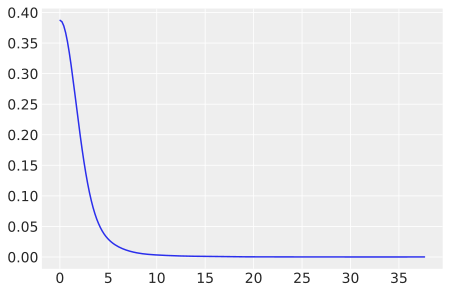

In [41]:
b = dist.LogNormal(0, 1).sample(PRNGKey(0), (int(1e4),))
az.plot_kde(b);

### Code 4.41

In [42]:
with numpyro.handlers.seed(rng=2971):
    N = 100  # 100 lines
    a = numpyro.sample("a", dist.Normal(178, 28), sample_shape=(N,))
    b = numpyro.sample("b", dist.LogNormal(0, 1), sample_shape=(N,))

### Code 4.42

In [43]:
# load data again, since it's a long way back
Howell1 = pd.read_csv("../data/Howell1.csv", sep=";")
d = Howell1
d2 = d[d["age"] >= 18]

# define the average weight, x-bar
xbar = d2.weight.mean()

# fit model
def model(weight, height):
    a = numpyro.sample("a", dist.Normal(178, 20))
    b = numpyro.sample("b", dist.LogNormal(0, 1))
    sigma = numpyro.sample("sigma", dist.Uniform(0, 50))
    mu = a + b * (weight - xbar)
    numpyro.sample("mu", dist.Delta(mu), obs=mu)
    numpyro.sample("height", dist.Normal(mu, sigma), obs=height)

m4_3 = AutoLaplaceApproximation(model)
svi = SVI(model, m4_3, optim.Adam(1), AutoContinuousELBO(),
          weight=d2.weight.values, height=d2.height.values)
init_state = svi.init(PRNGKey(0))
state, loss = lax.scan(lambda x, i: svi.update(x), init_state, np.zeros(1000))
p4_3 = svi.get_params(state)

### Code 4.43

In [44]:
def model(weight, height):
    a = numpyro.sample("a", dist.Normal(178, 20))
    log_b = numpyro.sample("log_b", dist.Normal(0, 1))
    sigma = numpyro.sample("sigma", dist.Uniform(0, 50))
    mu = a + np.exp(log_b) * (weight - xbar)
    numpyro.sample("height", dist.Normal(mu, sigma), obs=height)

m4_3b = AutoLaplaceApproximation(model)
svi = SVI(model, m4_3b, optim.Adam(1), AutoContinuousELBO(),
          weight=d2.weight.values, height=d2.height.values)
init_state = svi.init(PRNGKey(0))
state, loss = lax.scan(lambda x, i: svi.update(x), init_state, np.zeros(1000))
p4_3b = svi.get_params(state)

### Code 4.44

In [45]:
samples = m4_3.sample_posterior(PRNGKey(1), p4_3, (1000,))
print_summary(samples, 0.89, False)


                mean       std    median      5.5%     94.5%     n_eff     r_hat
         a    154.62      0.27    154.63    154.16    155.03    931.50      1.00
         b      0.91      0.04      0.90      0.84      0.97   1083.74      1.00
     sigma      5.08      0.19      5.08      4.79      5.41    949.65      1.00



### Code 4.45

In [46]:
vcov = np.cov(np.stack(list(samples.values()), axis=0))
np.round(vcov, 3)

DeviceArray([[0.075, 0.   , 0.001],
             [0.   , 0.002, 0.   ],
             [0.001, 0.   , 0.038]], dtype=float32)

### Code 4.46

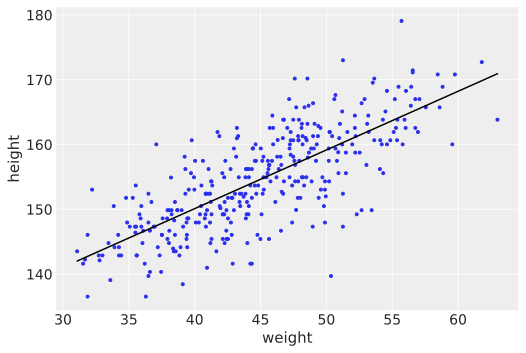

In [47]:
az.plot_pair(d2[["weight", "height"]].to_dict(orient="list"))
post = m4_3.sample_posterior(PRNGKey(1), p4_3, (1000,))
a_map = np.mean(post["a"])
b_map = np.mean(post["b"])
x = np.linspace(d2.weight.min(), d2.weight.max(), 101)
plt.plot(x, a_map + b_map * (x - xbar), "k");

### Code 4.47

In [48]:
post = m4_3.sample_posterior(PRNGKey(1), p4_3, (1000,))
{latent: list(post[latent][:5]) for latent in post}

{'a': [154.36615, 154.78511, 154.73534, 154.53842, 154.53549],
 'b': [0.974645, 0.8900049, 0.8190222, 0.83341044, 1.011918],
 'sigma': [4.976459, 4.943529, 5.2826023, 4.877721, 4.894869]}

### Code 4.48

In [49]:
N = 10
dN = d2[:N]

def model(weight, height):
    a = numpyro.sample("a", dist.Normal(178, 20))
    b = numpyro.sample("b", dist.LogNormal(0, 1))
    sigma = numpyro.sample("sigma", dist.Uniform(0, 50))
    mu = a + b * (weight - np.mean(weight))
    numpyro.sample("height", dist.Normal(mu, sigma), obs=height)

mN = AutoLaplaceApproximation(model)
svi = SVI(model, mN, optim.Adam(1), AutoContinuousELBO(),
          weight=dN.weight.values, height=dN.height.values)
init_state = svi.init(PRNGKey(0))
state, loss = lax.scan(lambda x, i: svi.update(x), init_state, np.zeros(1000))
pN = svi.get_params(state)

### Code 4.49

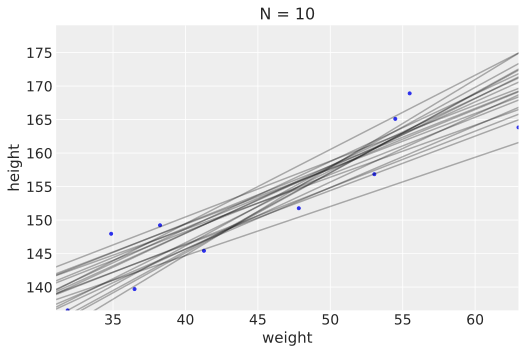

In [50]:
# extract 20 samples from the posterior
post = mN.sample_posterior(PRNGKey(1), pN, (20,))

# display raw data and sample size
ax = az.plot_pair(dN[["weight", "height"]].to_dict(orient="list"))
ax.set(xlim=(d2.weight.min(), d2.weight.max()),
       ylim=(d2.height.min(), d2.height.max()), title="N = {}".format(N))

# plot the lines, with transparency
x = np.linspace(d2.weight.min(), d2.weight.max(), 101)
for i in range(20):
    plt.plot(x, post["a"][i] + post["b"][i] * (x - dN.weight.mean()),
             "k", alpha=0.3)

### Code 4.50

In [51]:
post = m4_3.sample_posterior(PRNGKey(1), p4_3, (1000,))
mu_at_50 = post["a"] + post["b"] * (50 - xbar)

### Code 4.51

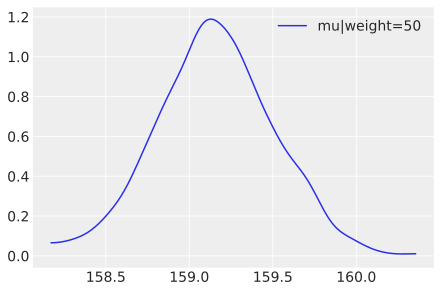

In [52]:
az.plot_kde(mu_at_50, label="mu|weight=50");

### Code 4.52

In [53]:
np.percentile(mu_at_50, q=(5.5, 94.5))

DeviceArray([158.5957 , 159.71445], dtype=float32)

### Code 4.53

In [54]:
mu = Predictive(m4_3.model, post, return_sites=["mu"]).get_samples(
    PRNGKey(2), d2.weight.values, d2.height.values)["mu"]
mu.shape, list(mu[:5, 0])

((1000, 352), [157.12938, 157.30838, 157.05736, 156.90125, 157.4044])

### Code 4.54

In [55]:
# define sequence of weights to compute predictions for
# these values will be on the horizontal axis
weight_seq = np.arange(start=25, stop=71, step=1)

# use predictive to compute mu
# for each sample from posterior
# and for each weight in weight_seq
mu = Predictive(m4_3.model, post, return_sites=["mu"]).get_samples(
    PRNGKey(2), weight_seq, None)["mu"]
mu.shape, list(mu[:5, 0])

((1000, 46), [134.88252, 136.99348, 138.36269, 137.87814, 134.30676])

### Code 4.55

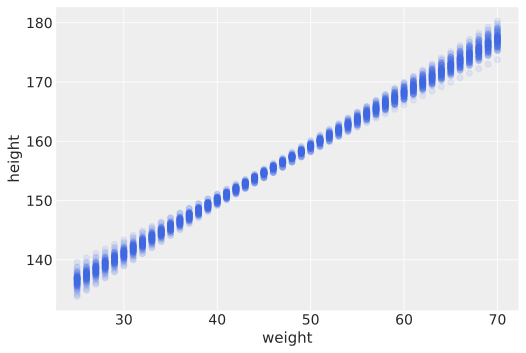

In [56]:
# use plot_kwargs={"alpha": 0} to hide raw data
az.plot_pair(d2[["weight", "height"]].to_dict(orient="list"),
             plot_kwargs={"alpha": 0})

# loop over samples and plot each mu value
for i in range(100):
    plt.plot(weight_seq, mu[i], "o", c="royalblue", alpha=0.1)

### Code 4.56

In [57]:
# summarize the distribution of mu
mu_mean = np.mean(mu, 0)
mu_PI = np.percentile(mu, q=(5.5, 94.5), axis=0)

### Code 4.57

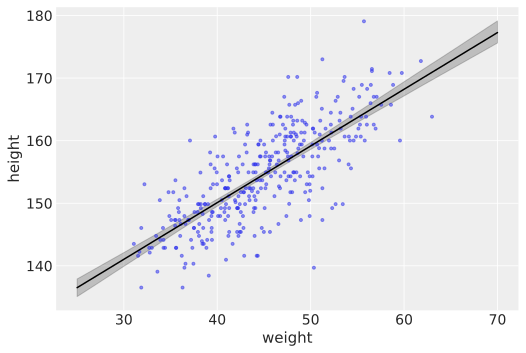

In [58]:
# plot raw data
# fading out points to make line and interval more visible
az.plot_pair(d2[["weight", "height"]].to_dict(orient="list"),
             plot_kwargs={"alpha": 0.5})

# plot the MAP line, aka the mean mu for each weight
plt.plot(weight_seq, mu_mean, "k")

# plot a shaded region for 89% PI
plt.fill_between(weight_seq, mu_PI[0], mu_PI[1], color="k", alpha=0.2);

### Code 4.58

In [59]:
post = m4_3.sample_posterior(PRNGKey(1), p4_3, (1000,))
mu_link = lambda weight: post["a"] + post["b"] * (weight - xbar)
weight_seq = np.arange(start=25, stop=71, step=1)
mu = vmap(mu_link)(weight_seq).T
mu_mean = np.mean(mu, 0)
mu_HPDI = hpdi(mu, prob=0.89, axis=0)

### Code 4.59

In [60]:
sim_height = Predictive(m4_3.model, post, return_sites=["height"]).get_samples(
    PRNGKey(2), weight_seq, None)["height"]
sim_height.shape, list(sim_height[:5, 0])

((1000, 46), [141.32513, 139.48373, 138.27194, 138.07433, 130.40279])

### Code 4.60

In [61]:
height_PI = np.percentile(sim_height, q=(5.5, 94.5), axis=0)

### Code 4.61

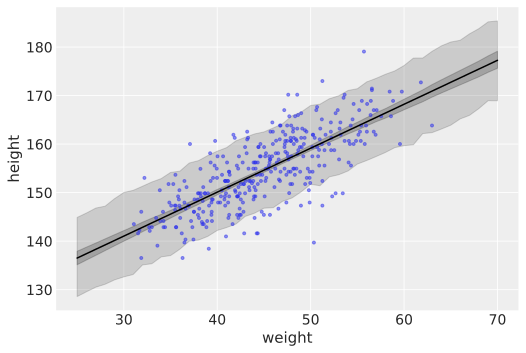

In [62]:
# plot raw data
az.plot_pair(d2[["weight", "height"]].to_dict(orient="list"),
             plot_kwargs={"alpha": 0.5})

# draw MAP line
plt.plot(weight_seq, mu_mean, "k")

# draw HPDI region for line
plt.fill_between(weight_seq, mu_HPDI[0], mu_HPDI[1], color="k", alpha=0.2)

# draw PI region for simulated heights
plt.fill_between(weight_seq, height_PI[0], height_PI[1], color="k",
                 alpha=0.15);

### Code 4.62

In [63]:
post = m4_3.sample_posterior(PRNGKey(1), p4_3, sample_shape=(int(1e4),))
sim_height = Predictive(m4_3.model, post, return_sites=["height"]).get_samples(
    PRNGKey(2), weight_seq, None)["height"]
height_PI = np.percentile(sim_height, q=(5.5, 94.5), axis=0)

### Code 4.63

In [64]:
post = m4_3.sample_posterior(PRNGKey(1), p4_3, (1000,))
weight_seq = np.arange(25, 71)
sim_height = vmap(lambda i, weight:
                  dist.Normal(post["a"] + post["b"] * (weight - xbar))
                  .sample(PRNGKey(i)))(np.arange(len(weight_seq)), weight_seq)
height_PI = np.percentile(sim_height, q=(5.5, 94.5), axis=0)

### Code 4.64

In [65]:
Howell1 = pd.read_csv("../data/Howell1.csv", sep=";")
d = Howell1
d.info()
d.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 544 entries, 0 to 543
Data columns (total 4 columns):
height    544 non-null float64
weight    544 non-null float64
age       544 non-null float64
male      544 non-null int64
dtypes: float64(3), int64(1)
memory usage: 17.1 KB


height     weight   age  male
0  151.765  47.825606  63.0     1
1  139.700  36.485807  63.0     0
2  136.525  31.864838  65.0     0
3  156.845  53.041915  41.0     1
4  145.415  41.276872  51.0     0

### Code 4.65

In [66]:
d["weight_s"] = (d.weight - d.weight.mean()) / d.weight.std()
d["weight_s2"] = d.weight_s ** 2

def model(weight_s, weight_s2, height):
    a = numpyro.sample("a", dist.Normal(178, 20))
    b1 = numpyro.sample("b1", dist.LogNormal(0, 1))
    b2 = numpyro.sample("b2", dist.Normal(0, 1))
    sigma = numpyro.sample("sigma", dist.Uniform(0, 50))
    mu = a + b1 * weight_s + b2 * weight_s2
    numpyro.sample("mu", dist.Delta(mu), obs=mu)
    numpyro.sample("height", dist.Normal(mu, sigma), obs=height)

m4_5 = AutoLaplaceApproximation(model)
svi = SVI(model, m4_5, optim.Adam(0.3), AutoContinuousELBO(),
          weight_s=d.weight_s.values, weight_s2=d.weight_s2.values,
          height=d.height.values)
init_state = svi.init(PRNGKey(0))
state, loss = lax.scan(lambda x, i: svi.update(x), init_state, np.zeros(1000))
p4_5 = svi.get_params(state)

### Code 4.66

In [67]:
samples = m4_5.sample_posterior(PRNGKey(1), p4_5, (1000,))
print_summary(samples, 0.89, False)


                mean       std    median      5.5%     94.5%     n_eff     r_hat
         a    146.05      0.36    146.03    145.47    146.58   1049.96      1.00
        b1     21.75      0.30     21.75     21.25     22.18    886.88      1.00
        b2     -7.79      0.28     -7.79     -8.21     -7.32   1083.62      1.00
     sigma      5.78      0.17      5.78      5.49      6.02    973.22      1.00



### Code 4.67

In [68]:
weight_seq = np.linspace(start=-2.2, stop=2, num=30)
pred_dat = {"weight_s": weight_seq, "weight_s2": weight_seq ** 2,
            "height": None}
post = m4_5.sample_posterior(PRNGKey(1), p4_5, (1000,))
predictive = Predictive(m4_5.model, post, return_sites=["mu", "height"])
mu = predictive.get_samples(PRNGKey(2), **pred_dat)["mu"]
mu_mean = np.mean(mu, 0)
mu_PI = np.percentile(mu, q=(5.5, 94.5), axis=0)
sim_height = predictive.get_samples(PRNGKey(2), **pred_dat)["height"]
height_PI = np.percentile(sim_height, q=(5.5, 94.5), axis=0)

### Code 4.68

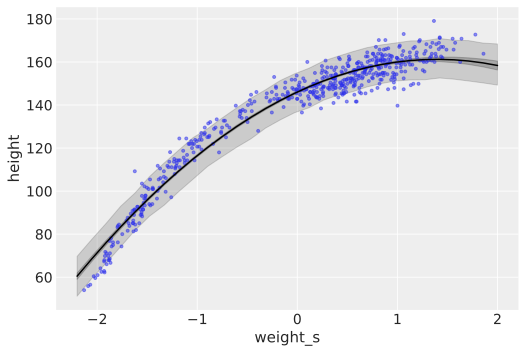

In [69]:
az.plot_pair(d[["weight_s", "height"]].to_dict(orient="list"),
             plot_kwargs={"alpha": 0.5})
plt.plot(weight_seq, mu_mean, "k")
plt.fill_between(weight_seq, mu_PI[0], mu_PI[1], color="k", alpha=0.2)
plt.fill_between(weight_seq, height_PI[0], height_PI[1], color="k",
                 alpha=0.15);

### Code 4.69

In [70]:
d["weight_s3"] = d.weight_s ** 3

def model(weight_s, weight_s2, weight_s3, height):
    a = numpyro.sample("a", dist.Normal(178, 20))
    b1 = numpyro.sample("b1", dist.LogNormal(0, 1))
    b2 = numpyro.sample("b2", dist.Normal(0, 1))
    b3 = numpyro.sample("b3", dist.Normal(0, 1))
    sigma = numpyro.sample("sigma", dist.Uniform(0, 50))
    mu = a + b1 * weight_s + b2 * weight_s2 + b3 * weight_s3
    numpyro.sample("height", dist.Normal(mu, sigma), obs=height)

m4_6 = AutoLaplaceApproximation(model)
svi = SVI(model, m4_6, optim.Adam(0.3), AutoContinuousELBO(),
          weight_s=d.weight_s.values, weight_s2=d.weight_s2.values,
          weight_s3=d.weight_s3.values, height=d.height.values)
init_state = svi.init(PRNGKey(0))
state, loss = lax.scan(lambda x, i: svi.update(x), init_state, np.zeros(1000))
p4_6 = svi.get_params(state)

### Code 4.70

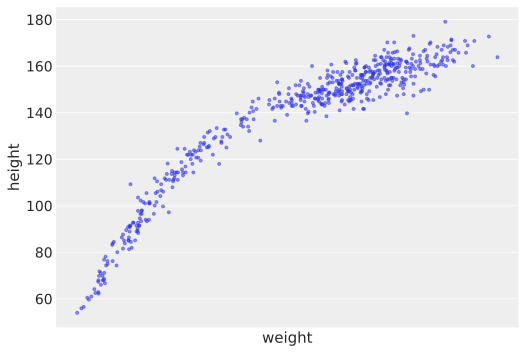

In [71]:
ax = az.plot_pair(d[["weight_s", "height"]].to_dict(orient="list"),
                  plot_kwargs={"alpha": 0.5})
ax.set(xlabel="weight", ylabel="height", xticks=[])
fig = plt.gcf()

### Code 4.71

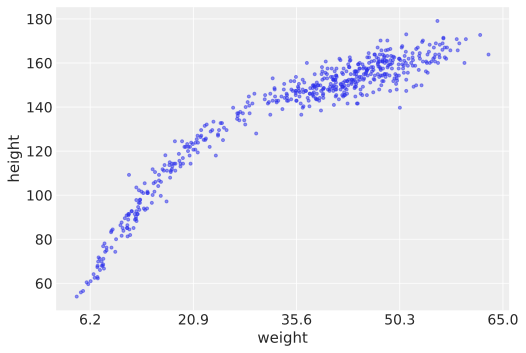

In [72]:
at = np.array([-2, -1, 0, 1, 2])
labels = at * d.weight.std() + d.weight.mean()
ax.set_xticks(at)
ax.set_xticklabels([round(label, 1) for label in labels])
fig

### Code 4.72

In [73]:
cherry_blossoms = pd.read_csv("../data/cherry_blossoms.csv", sep=";")
d = cherry_blossoms
print_summary({"year": d.year.dropna().values}, 0.89, False)
print_summary({"doy": d.doy.dropna().values}, 0.89, False)
print_summary({"temp": d.temp.dropna().values}, 0.89, False)
print_summary({"temp_upper": d.temp_upper.dropna().values}, 0.89, False)
print_summary({"temp_lower": d.temp_lower.dropna().values}, 0.89, False)


                mean       std    median      5.5%     94.5%     n_eff     r_hat
      year   1408.00    350.88   1408.00    801.00   1882.00      2.51      2.65


                mean       std    median      5.5%     94.5%     n_eff     r_hat
       doy    104.54      6.41    105.00     93.00    113.00    111.98      1.00


                mean       std    median      5.5%     94.5%     n_eff     r_hat
      temp      6.14      0.66      6.10      5.03      7.13     22.07      1.02


                  mean       std    median      5.5%     94.5%     n_eff     r_hat
  temp_upper      7.19      0.99      7.04      5.66      8.54     10.11      1.24


                  mean       std    median      5.5%     94.5%     n_eff     r_hat
  temp_lower      5.10      0.85      5.14      3.79      6.37     21.90      1.11



### Code 4.73

In [74]:
d2 = d[d.temp.notna()]  # not NaN cases on temp
num_knots = 15
knot_list = np.quantile(d2.year.values.astype(float),
                        q=np.linspace(0, 1, num=num_knots))

### Code 4.74

In [75]:
knots = onp.pad(knot_list, (3, 3), mode="edge")
B = BSpline(knots, np.identity(num_knots + 2), k=3)(d2.year.values)

### Code 4.75

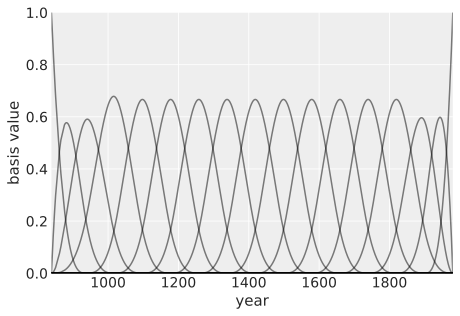

In [76]:
plt.subplot(xlim=(d2.year.min(), d2.year.max()), ylim=(0, 1),
            xlabel="year", ylabel="basis value")
for i in range(B.shape[1]):
    plt.plot(d2.year, B[:, i], "k", alpha=0.5)

### Code 4.76

In [77]:
def model(B, T):
    a = numpyro.sample("a", dist.Normal(6, 10))
    w = numpyro.sample("w", dist.Normal(0, 1), sample_shape=B.shape[1:])
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    mu = a + B @ w
    numpyro.sample("mu", dist.Delta(mu), obs=mu)
    numpyro.sample("T", dist.Normal(mu, sigma), obs=T)

start = {"w": np.zeros(B.shape[1])}
m4_7 = AutoLaplaceApproximation(model, init_strategy=init_to_value(start))
svi = SVI(model, m4_7, optim.Adam(1), AutoContinuousELBO(),
          B=B, T=d2.temp.values)
init_state = svi.init(PRNGKey(0))
state, loss = lax.scan(lambda x, i: svi.update(x), init_state, np.zeros(1000))
p4_7 = svi.get_params(state)

### Code 4.77

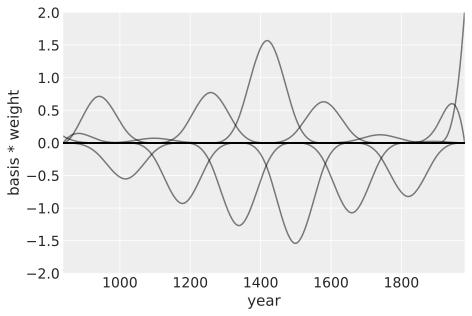

In [78]:
post = m4_7.sample_posterior(PRNGKey(1), p4_7, (1000,))
w = np.mean(post["w"], 0)
plt.subplot(xlim=(d2.year.min(), d2.year.max()), ylim=(-2, 2),
            xlabel="year", ylabel="basis * weight")
for i in range(B.shape[1]):
    plt.plot(d2.year, w[i] * B[:, i], "k", alpha=0.5)

### Code 4.78

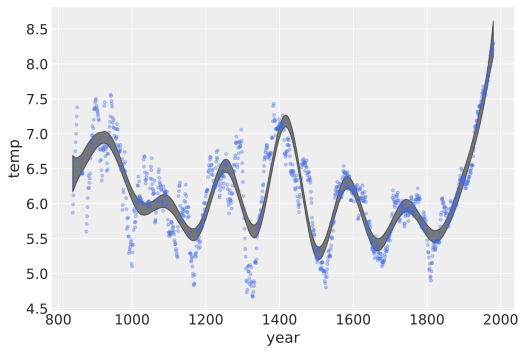

In [79]:
mu = Predictive(m4_7.model, post, return_sites=["mu"]).get_samples(
    PRNGKey(2), B, None)["mu"]
mu_PI = np.percentile(mu, q=(1.5, 98.5), axis=0)
az.plot_pair(d2[["year", "temp"]].astype(float).to_dict(orient="list"),
             plot_kwargs={"c": "royalblue", "alpha": 0.3})
plt.fill_between(d2.year, mu_PI[0], mu_PI[1], color="k", alpha=0.5);

### Code 4.79

In [80]:
def model(B, T):
    a = numpyro.sample("a", dist.Normal(6, 10))
    w = numpyro.sample("w", dist.Normal(0, 1), sample_shape=B.shape[1:])
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    mu = a + np.sum(B * w, axis=-1)
    numpyro.sample("mu", dist.Delta(mu), obs=mu)
    numpyro.sample("T", dist.Normal(mu, sigma), obs=T)

start = {"w": np.zeros(B.shape[1])}
m4_7alt = AutoLaplaceApproximation(model, init_strategy=init_to_value(start))
svi = SVI(model, m4_7alt, optim.Adam(1), AutoContinuousELBO(),
          B=B, T=d2.temp.values)
init_state = svi.init(PRNGKey(0))
state, loss = lax.scan(lambda x, i: svi.update(x), init_state, np.zeros(1000))
p4_7alt = svi.get_params(state)

### Code 4.80

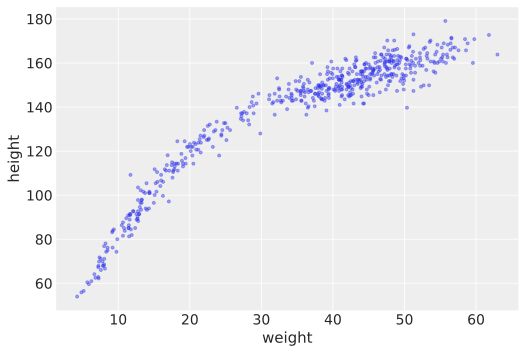

In [81]:
az.plot_pair(Howell1[["weight", "height"]].to_dict(orient="list"),
             plot_kwargs={"alpha": 0.4});